# PROJECT - *My Way* of seeing music covers
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [128]:
# Import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from io import StringIO
import sys
import requests
from bs4 import BeautifulSoup
import pickle
import os
import glob
from pathlib import Path
from dateutil import parser
import re

## Notebook plan
1. [Data importation](#part1)
2. [Addition of the language and the year of each track](#part2) (SHS website web-scraping)
3. [Data Wrangling and Find original song](#part3)
4. [Addition of the genres and artist location](#part4)
5. [Addition of the tempo and popularity of each track](#part5) (Access to track files through the cluster)
6. [Data Analysis](#part6)

<a id='part1'></a>
## 1. Data importation
Download available additional files containing metadata about our dataset from the cluster (dataset/million-songs_untar/)
- tracks_per_year.txt
- unique_tracks.txt
- unique_artists.txt
- artist_location.txt

Use the Second Hand Songs (SHS) dataset that was created through a collaboration between the Million Songs team and the Second Hand Songs website (https://secondhandsongs.com/). These data are splitted into two datasets to allowed machine learnings algorithms (a train and a test set).
- SHS_testset.txt
- SHS_trainset.txt
Since we don't need this distinction for our data analysis, we merged these two datasets.

The use of external dataset (LastFM) for the genres and the use of the track files (.h5) available through the cluster are commented in part 4 and 5.

Some general informations about our data :
- All the additional files were downloaded from the cluster giving all the metadata of the Million Songs dataset. They will help to elaborate a plan and a script will then search more information about a specific track (h5 files in the cluster) maybe using cluster cpu. The path to access to a track in the cluster is for example million-songs/data/A/A/A (with the 3 letters at the end being the 3rd, 4th and 5th letter on the track id).
- The music covers will be detected using another dataset (SecondHandSongs), we have the choice to use the downloadable dataset containing 18,196 tracks (all with a connection to the MSD dataset), or to web-scrapp the SHS website (https://secondhandsongs.com/) where we have much more information (522 436 covers) but not necessarly connected to our MSD dataset. The SHS API is RESTful (return a JSON object) and will be used to provide additional or missing informations (localisation, language of the song, ...) in our dataset.
- Some artist are geolocalised (30% of the MSD total artists) on the artist_location dataframe.

In [129]:
#Load Additional files
tracks_per_year=pd.read_csv('data/AdditionalFiles/tracks_per_year.txt',delimiter='<SEP>',engine='python',header=None,index_col=1,names=['year','trackID','artist','title'])
unique_tracks=pd.read_csv('data/AdditionalFiles/unique_tracks.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['trackID','songID','artist','title'])
unique_artists=pd.read_csv('data/AdditionalFiles/unique_artists.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['artistID','artistMID','randomTrack','name'])
artist_location=pd.read_csv('data/AdditionalFiles/artist_location.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['artistID','lat','long','name','location'])

In [130]:
#Check if indexes is unique and print the number of elements for each dataframe
print('Dataframe (Unique index, Number of elements)')
print('tracks_per_year ',(tracks_per_year.index.is_unique,tracks_per_year.shape[0]))
print('unique_tracks ',(unique_tracks.index.is_unique,unique_tracks.shape[0]))
print('unique_artists ',(unique_artists.index.is_unique,unique_artists.shape[0]))
print('artist_location ',(artist_location.index.is_unique,artist_location.shape[0]))

Dataframe (Unique index, Number of elements)
tracks_per_year  (True, 515576)
unique_tracks  (True, 1000000)
unique_artists  (True, 44745)
artist_location  (True, 13850)


The covers dataset (SHS_testset.txt and SHS_trainset.txt) were organised in a very special way where group (named "cliques") list some tracks that are interrelated (music covers and original track). The function **read_shs_files** is used to import the files keeping the "clique" configuration.

In [131]:
def read_shs_files(pathToFile):
    f = open(pathToFile)
    s = StringIO()
    cur_ID = None
    for ln in f:
        if not ln.strip():
                continue
        if ln.startswith('%'):
                cur_ID = ln.replace('\n','<SEP>',1)
                continue
        if cur_ID is None:
                print ('NO ID found')
                sys.exit(1)
        s.write(cur_ID + ln)
    s.seek(0)
    df = pd.read_csv(s,delimiter='<SEP>',engine='python',header=None,names=['shsID','trackID','artistID','shsPerf'])
    return df

In [132]:
#Import the two SHS datasets and concatenate them
SHS_testset=read_shs_files('data/SHS_testset.txt')
SHS_trainset=read_shs_files('data/SHS_trainset.txt')
covers=pd.concat([SHS_testset,SHS_trainset])
covers.shsID=covers.shsID.str.strip('%')
covers.head()

,shsID,trackID,artistID,shsPerf
0,"115402,74782, Putty (In Your Hands)",TRJVDMI128F4281B99,AR46LG01187B98DB5D,74784
1,"115402,74782, Putty (In Your Hands)",TRNJXCO128F92E1930,ARQD13K1187B98E441,138584
2,"24350, I.G.Y. (Album Version)",TRIBOIS128F9340B19,ARUVZYG1187B9B2809,24350
3,"24350, I.G.Y. (Album Version)",TRGXZDU128F9301E53,AR4LE591187FB3FCFB,24363
4,"79178, When The Catfish Is In Bloom",TRQSIOY128F92FACA7,ARU75JD1187FB38B79,79178


As said before, our dataset was created from a collaboration between the Million Songs Dataset (MSD) and the Second Hand Songs Dataset (SHS).  

The MSD consists of almost all the information available through the Echo Nest API for one million popular tracks and the *trackID* and *artistID* are directly based on the Echo Nest structure.   
More specifically, the *trackID* is the unique identifier of a track (connection with unique_tracks.txt) and the *artistID* is the unique identifier of an artist (connection with unique_artists.txt). The *trackID* is also the path used to navigate through the MSD directory and access to a specific song (through the cluster).  

The *shsPerf* corresponds to the SHS identifier of a song and this information is sometimes missing. Exploring the SHS website, we found that the page of a specific song can be accessed with different paths using the *shsPerf* information :
- https://secondhandsongs.com/performance/ [shsPerf]
- https://secondhandsongs.com/work/ [shsPerf]

We have deducted that only original music song has both a work page and a performance page, covers having only performance page. In some cases, the *shsPerf* for an original music song is not the same if we want to reach the performance page or the work page and in our dataset, we assumed that the *shsPerf* was only performance id.

The structure of the first column was impossible to decode and the informations contained as the name of the song can be found elsewhere (unique_tracks.txt). Thus, the column will only be used to define a clique_id for each track. 

In [133]:
#Convert shsID to clique id (first convert to category and get a code)
covers=covers.assign(clique_id=(covers.shsID.astype('category')).cat.codes)
#Remove the shsID column (useless since we have the clique_id now)
covers.drop('shsID',axis=1,inplace=True)

In order to use the informations contained in the metadata files first, we merged some necessary attributes (name of the artist, title of the track, released date) from the MSD dataframes named before.

In [134]:
#Merge with unique_artists dataframe to find the artist name for each track (no taking consideration of featuring since we take only the name of the artist assigned with the track)
covers=covers.merge(unique_artists[['name']],how='left',left_on='artistID',right_index=True)
#Merge with unique_tracks dataframe to find the track name
covers=covers.merge(unique_tracks[['title']],how='left',left_on='trackID',right_index=True)
#Merge with tracks_per_year dataframe to find the year of each track
covers=covers.merge(tracks_per_year[['year']],how='left',left_on='trackID',right_index=True)

In [135]:
covers=covers.sort_values(['clique_id', 'year'], ascending=[True, True]).reset_index() #Reset index according clique_id and year
covers.drop('index',axis=1,inplace=True) #Drop the previous index

In [136]:
covers.head()

,trackID,artistID,shsPerf,clique_id,name,title,year
0,TRGDMZP128F42BC52B,ARB1DDF1187FB4FCFB,-1,0,Louis Armstrong,Stardust,1988.0
1,TRCATYW12903D038FE,ARGJEEO1271F573FD6,-1,0,Artie Shaw and his orchestra,Stardust,1988.0
2,TRVMZJZ128F4270CE4,ARY0HTV1187FB4A1B1,-1,0,Hoagy Carmichael,Star Dust,1999.0
3,TRKOINL128F42926C3,ARQ5FSZ1187B98AD74,-1,0,Connee Boswell & Sy Oliver Orchestra,Star Dust,NaN
4,TROJZTF128F428B546,ARJN76O1187FB43C99,-1,1,Ana Belén,Yo Vengo A Ofrecer Mi Corazon,2001.0


Here is printed some useful informations about the cover dataset (the basis of our work) :

In [137]:
print('Number of tracks :', covers.shape[0])
print('Number of cliques :', len(covers.clique_id.unique()))
print('Number of unique tracks :', len(covers.trackID.unique())) 
print('Number of unique artists :', len(covers.artistID.unique()))
print('Number of missing trackID :', len(covers[covers.trackID.isnull()]))
print('Number of missing artistID :', len(covers[covers.artistID.isnull()]))
print('Number of missing years :', len(covers[covers.year.isnull()]))
print('Number of invalid shsPerf :', len(covers[covers.shsPerf<0]))

Number of tracks : 18196
Number of cliques : 5854
Number of unique tracks : 18196
Number of unique artists : 5578
Number of missing trackID : 0
Number of missing artistID : 0
Number of missing years : 4796
Number of invalid shsPerf : 3075


An important step that we will faced in the data wrangling process will be to differentiate the original song and the music covers inside each clique.  
We thought using the released year that is provided in the track_per_year.txt file but with 4796 tracks (26%) with missing years, we need to find another way to get them. Furthermore, year isn't necessarly sufficient informations to discriminate the tracks (cover appears sometimes in the same year than the original one), thus it will be better to have the released date for ALL the tracks if the information is available.

<a id='part2'></a>
## 2. Addition of the language and the year of each track (SHS website web-scraping)

Some useful informations can be found in a music cover page
In the Second Hand Song website (https://secondhandsongs.com/), each song page can be access by a specific id (shsPerf in our dataset) and some useful information about the song is provided as its language and its released date (not only the year). Furthermore, in case of music cover page, a link to the original song page is also present.

Thus, we decided to improve our dataset using web-scrapping of the SHS website.

As said before, the performance id (that is used in the URL to access to the song page) is available in our cover dataframe (shsPerf) but 3075 tracks (17%) have unvalid shsPerf (shsPerf=-1) and that make access to their page impossible.  
Thus, we have two ways to access extract the language/year/original song via web-scrapping :
- For valid SHS performance ID, access to the performance page (e.g. 'https://secondhandsongs.com/performance/1983') and web-scrapping of the Language and Released date informations using the perfInfo() function.
- For invalid SHS performance ID, API request to the search page (e.g. 'https://secondhandsongs.com/search/performance?title=blackbird&performer=beatles'), extract the perf ID with the find_PerfID() and then use the perfInfo() function.


In [138]:
covers.shape

(18196, 7)

The name of the artist is different if we use the information provided in the unique_artists.txt or in the unique_tracks.txt. Indeed, in order to assign a specific *artistID* to each track, the MSD team has splitted the featuring tracks keeping in an arbitrary way one of the artist.  
Both informations will be useful depending the precision we want to use in our algorithms, that's why two field corresponds to artist names (*name* and *artist*) in our cover dataframe.

In [139]:
#Merge with the unique_tracks dataframe to get the name of the artist for the track (take featuring as well)
covers=covers.merge(unique_tracks[['artist']],how='left',left_on='trackID',right_index=True)

In [140]:
# API request to find the shsPerf for unvalid ones (shsPerf=-1)
# Corresponds to a detailed search in the SHS website with a contains condition on title and on artist

def find_shsPerf(x):
    
    # x corresponds to the index position of each track (in order to execute the function on the entire dataframe)
    title=covers.iloc[x]['title'] 
    artist=covers.iloc[x]['name']
    shsPerf=covers.iloc[x]['shsPerf']
    
    # In case of unvalid (missing) shsPerf
    if shsPerf<0: 
        title=title.replace('.', '').replace('_', '').replace('/', '').lower().replace(' ','+')
        artist=artist.replace('.', '').replace('_', '').replace('/', '').lower().replace(' ','+')
        r=requests.get('https://secondhandsongs.com/search/performance?title='+title+'&op_title=contains&performer='+artist+'&op_performer=contains')
        soup = BeautifulSoup(r.text, 'html.parser')
        results=soup.find('tbody')

        if results is None :
            # Assign default value of 0 if no results found in the detailed search request
            new_shsPerf=0
        else:
            # Take the first result of the detailed search (since it is sorted according relevance)
            new_shsPerf=int(results.find('a',attrs={'class':'link-performance'})['href'].split('/')[2])
    
    # Keep as it is if the shsPerf is valid
    else :
        new_shsPerf=shsPerf
        
        
    return new_shsPerf

In [141]:
#Find the shsPerf for the tracks which doesn't have valid ones
#covers_withSHS=covers_p.shsPerf.index.map(lambda x: find_shsPerf(x)) 

In [142]:
#pickle.dump(covers_withSHS,open('data/covers_1.p','wb'))
covers['shsPerf']=pickle.load(open("data/covers_1.p","rb"))

In [143]:
# Number of missing shsPerf in our dataset
len(covers[covers.shsPerf==0])

1088

We still can't access the SHS pages for **1088** music covers (6%) and the missing *shsPerf* are assigned to a default value of 0. We will need to decide if remove them since it will be impossible to find the missing release date and/or the language of the track.
For now, we will compute the perfInfo_SHS for all the dataset.

In [144]:
# API request to extract the language, the released date and the shsPerf of the original song
# Computes for all the tracks in our dataset

def perfInfo_SHS(shsPerf):
        
    # If the shsPerf is missing in our dataset assign default values "Unavailable" for the three fields
    if shsPerf==0:
        perfLanguage='Unavailable'
        perfDate='Unavailable'
        original_shsPerf='Unavailable'
     
    # If we have shsPerf information in our dataset
    else :
        r = requests.get('https://secondhandsongs.com/performance/'+str(shsPerf)) # Access to the song page on SHS
        soup = BeautifulSoup(r.text, 'html.parser')
        perfMeta=soup.find('dl',attrs={'class':'dl-horizontal'})
        
        # If no metadata of the song is found, assign default values "Missing" to differentiate unreachable informations
        # and missing ones.
        if perfMeta is None:
            perfLanguage='Missing'
            perfDate='Missing'
            original_shsPerf='Missing'
        else :
            # Extract language
            perfLanguage=perfMeta.find('dd',attrs={'itemprop':'inLanguage'})
            if perfLanguage is None :
                perfLanguage='Missing'
            else :
                perfLanguage=perfLanguage.text

            # Extract released date    
            perfDate=perfMeta.find('div',attrs={'class':'media-body'})
            if perfDate is None :
                perfDate='Missing'
            else :
                perfDate=perfDate.find('p').text.split('\n')[2].strip(' ')

            #Extract original shsPerf (work or performance ID) 
            original_section=soup.find('section',attrs={'class':'work-originals'})
            versions_section=soup.find('section',attrs={'id':'entity-section'})
            
            if original_section is None :
                if versions_section is None :
                    original_shsPerf='Missing'
                else :
                    
                    original_shsPerf=versions_section.find('a')['href']
                    if original_shsPerf is None :
                        original_shsPerf='Missing'
                    else :
                        original_shsPerf=original_shsPerf.split('/')[2]

            else :
                original_shsPerf=original_section.find('div',attrs={'class':'media-body'})
                original_shsWork=original_section.find('a',attrs={'class':'link-work'})['href']
                
                if original_shsPerf is None :
                    original_shsPerf=original_shsWork.split('/')[2]
                else :
                    original_shsPerf=original_shsPerf.find('a')['href'].split('/')[2]

    return perfLanguage,perfDate,original_shsPerf

In [145]:
# Add informations found with web-scrapping
#covers['language'], \
#covers['date'], \
#covers['original_shsPerf']= zip(*covers.shsPerf.map(perfInfo_SHS))

In [146]:
covers.head()

,trackID,artistID,shsPerf,clique_id,name,title,year,artist
0,TRGDMZP128F42BC52B,ARB1DDF1187FB4FCFB,0,0,Louis Armstrong,Stardust,1988.0,Louis Armstrong & His Orchestra
1,TRCATYW12903D038FE,ARGJEEO1271F573FD6,0,0,Artie Shaw and his orchestra,Stardust,1988.0,Artie Shaw and his orchestra
2,TRVMZJZ128F4270CE4,ARY0HTV1187FB4A1B1,412972,0,Hoagy Carmichael,Star Dust,1999.0,Hoagy Carmichael
3,TRKOINL128F42926C3,ARQ5FSZ1187B98AD74,0,0,Connee Boswell & Sy Oliver Orchestra,Star Dust,NaN,Connee Boswell & Sy Oliver Orchestra
4,TROJZTF128F428B546,ARJN76O1187FB43C99,0,1,Ana Belén,Yo Vengo A Ofrecer Mi Corazon,2001.0,Ana Belén


In [147]:
#pickle.dump(covers,open('data/covers_2.p','wb'))
covers=pickle.load(open("data/covers_2.p","rb"))

In [148]:
print('Number of unavailable language : ', len(covers[covers.language=='Unavailable']) )
print('Number of missing language : ', len(covers[covers.language=='Missing']) )
print('Total number of tracks with no language information : ', len((covers[covers.language=='Missing']) | (covers[covers.language=='Unavailable'])))
print('')
print('Number of unavailable released date :' ,len(covers[covers.date=='Unavailable']))
print('Number of missing released date :' ,len(covers[covers.date=='Missing']))
print('Total number of tracks with no released date : ', len((covers[covers.date=='Missing']) | (covers[covers.original_shsPerf=='Unavailable']))) 
print('')
print('Number of unavailable original shsPerf :' ,len(covers[covers.original_shsPerf=='Unavailable']))
print('Number of missing original shsPerf :' ,len(covers[covers.original_shsPerf=='Missing']))
print('Total number of tracks with no original shsPerf information : ', len((covers[covers.original_shsPerf=='Missing']) | (covers[covers.original_shsPerf=='Unavailable']))) 

Number of unavailable language :  1088
Number of missing language :  1426
Total number of tracks with no language information :  2514

Number of unavailable released date : 1088
Number of missing released date : 159
Total number of tracks with no released date :  1247

Number of unavailable original shsPerf : 1088
Number of missing original shsPerf : 145
Total number of tracks with no original shsPerf information :  1233


<a id='part3'></a>
## 3. Find the original song

After the extraction of the different elements, we noticed several problems :

1\. The track year (year) is sometimes different form the released date (date) we've extracted from the SHS website, we will prefer the data information found in the SHS website after some manual verifications.


2\. We found several cases where language (14%) and/or released year (7%) information were missing or unavailable. Since we have a small dataset, we cannot allowed to delete a lot of tracks so we kept these tracks and handle this issue in the data analysis.


3\. A total of 1233 tracks (7%) don't have original shsPerf information so we'll need to face this issue in our algorithm to find the original track for each clique.


4\. We also noticed that in case of cliques with 2 elements and with one having shsPerf=0, if the other one has an original shsPerf, we couldn't link to the other song present in the clique (and it's generally the original one). Thus, we created a special algorithm **attribute_original()** to adress this issue.


5\. Some original performance that were found in the SHS website don't appear in the clique. And we can extract all informations in the SHS website so we decided to choose the earlier released song as original in this case. Furthermore, in some cases, several original shsPerf are returned inside one clique. We created an algorithm **find_original_track()** that return a unique shsPerf that is considered as the original track for each clique.


6\. There are duplicated shsPerf in our dataset, it means that we've extracted the same informations from the SHS website (*original shsPerf*, *language* and *released year*) for these tracks. We have checked the concerned tracks and it is mostly duplicated tracks (although they have different *trackID* in the Million Song Dataset). Since they will bias our statistics, we decided to remove the duplicated shsPerf, keeping the one with the fewest missing fields.
The function **duplicate_to_keep()** handles this issue.


7\. Same original shsPerf were found in different cliques, and one *original shsPerf* was linking to a track in another clique. After some verifications, we noticed that some cliques needed to be merged. We created a function **merge_cliques()** that handles this issue.


8\. In cliques where no original shsPerf is found and where released date for at least one track is present, it is impossible to define an original song. Thus, these cliques need to be removed from our dataset.


In [149]:
# Resolve ISSUE n°1
# Merge the informations concerning the released date (from MSD and SHS) keeping SHS information in priority
covers['date'] = covers.apply(lambda row: row['year'] if ((row['date']=='Missing') | (row['date']=='Unavailable')) else row['date'],axis=1)
covers.drop('year',axis=1,inplace=True)

In [150]:
print('Number of tracks without released date information after the merged :', len(covers[covers.date.isnull()]))

Number of tracks without released date information after the merged : 358


In [151]:
# Put all the missing shsPerf (unavailable or missing) to 0 and convert to int
covers['original_shsPerf'] = np.where(((covers['original_shsPerf']=='Unavailable') | (covers['original_shsPerf']=='Missing')), 0, covers['original_shsPerf'])
covers['original_shsPerf']=covers['original_shsPerf'].astype(int)

In [152]:
# Compute the frequency for each original shsPerf and sort values according frequency
freq_original=covers.groupby(['clique_id','original_shsPerf'],as_index=False)['clique_id'].agg({'freq':'count'})
freq_original.sort_values(['clique_id', 'freq'], ascending=[True, False],inplace=True)
freq_original.set_index(['clique_id', 'freq'],drop=False,inplace=True)
freq_original.drop('clique_id',axis=1,inplace=True)
freq_original.head()

original_shsPerf  freq
clique_id freq                        
0         3                    0     3
          1                19677     1
1         2                    0     2
2         2                16660     2
3         1               142889     1

In [153]:
# For each clique, count the number of different original shsPerf (including Missing or Unavailable informations)
# and the total number of tracks contained in the clique
freq_original_agg=freq_original[['freq']].groupby(by='clique_id').agg([{'nbrow':'count','nbfreq':'sum'}])
freq_original_agg.columns=freq_original_agg.columns.droplevel()
freq_original_agg.columns=freq_original_agg.columns.droplevel()
freq_original_agg['clique_id']=freq_original_agg.index
freq_original_agg.head()

/Users/anaisladoy/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:2946: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  results[name] = obj.aggregate(func)


,nbrow,nbfreq,clique_id
clique_id,,,
0,2,4,0
1,1,2,1
2,1,2,2
3,2,2,3
4,1,2,4


In [154]:
# Resolve ISSUE n°4
# Keep only clique where there are 2 elements with two different original_shsPerf
freq_original_agg=freq_original_agg[(freq_original_agg.nbrow==2) & (freq_original_agg.nbfreq==2)]
freq_original_agg.head()

,nbrow,nbfreq,clique_id
clique_id,,,
3,2,2,3
6,2,2,6
8,2,2,8
12,2,2,12
13,2,2,13


In [155]:
# Function to resolve ISSUE n°4

def attribute_original(clique_id) :

    first_elem=covers_clique.loc[clique_id].iloc[0]
    second_elem=covers_clique.loc[clique_id].iloc[1]
    
    if (first_elem.original_shsPerf==0) | (second_elem.original_shsPerf==0) :
        if (first_elem.original_shsPerf==0) & (second_elem.original_shsPerf!=second_elem.shsPerf):
            elemTrack=first_elem.name
            elemSHS=second_elem.original_shsPerf
            
        elif (second_elem.original_shsPerf==0) & (first_elem.original_shsPerf!=first_elem.shsPerf):
            elemTrack=second_elem.name
            elemSHS=first_elem.original_shsPerf
        else :
            elemTrack=np.nan
            elemSHS=np.nan
            
    else :
        elemTrack=np.nan
        elemSHS=np.nan
        
    return elemTrack, elemSHS

In [156]:
replace_shs=pd.DataFrame(columns=['elemTrack','elemSHS'])
replace_shs['elemTrack'], \
replace_shs['elemSHS'] = zip(*freq_original_agg.clique_id.map(attribute_original))
replace_shs.dropna(axis=0,inplace=True)
replace_shs.elemSHS=replace_shs.elemSHS.astype(int)

In [157]:
covers=covers.merge(replace_shs,how='left',left_on='trackID',right_on='elemTrack')
covers['shsPerf'] = np.where(covers['elemSHS'].notnull(), covers['elemSHS'], covers['shsPerf'])
covers.drop(['elemTrack','elemSHS'],axis=1,inplace=True)
covers.shsPerf=covers.shsPerf.astype(int)

In [158]:
#pickle.dump(covers,open('data/covers_3.p','wb'))
covers=pickle.load(open("data/covers_3.p","rb"))

In [ ]:
#Create a multilevel index with clique_id and track_id that will be used to exectute the algorithm to find original song
covers_clique=covers.copy()
covers_clique.set_index(['clique_id','trackID'],inplace=True)
covers_clique.head()

In [159]:
# Resolve ISSUE n°5

# Function to attribute a unique original shsPerf to each clique
def find_original_track(clique_id,max_freq_row):
    
    nb_elems=freq_original.loc[clique_id].original_shsPerf.count()
    unique_shsPerf=covers.shsPerf.unique()[1:];

    if nb_elems == 1 :

        first_elem=max_freq_row.original_shsPerf;
        if first_elem !=0:
            if (first_elem in(unique_shsPerf))==True :
                original_song=first_elem;
            else :
                original_song='Unknown';
        
        else :
            original_song='Unknown';
    
    if nb_elems == 2 :
        first_elem=max_freq_row.original_shsPerf;
        second_elem=freq_original.loc[clique_id].iloc[1].original_shsPerf;
        
        if first_elem != 0:
            if (first_elem in (unique_shsPerf))==True :
                original_song=first_elem;
            elif (second_elem in (unique_shsPerf))==True :
                original_song=second_elem;
            else : #Put the reference as the first
                original_song='Unknown';
        
        else :
            if (second_elem in (unique_shsPerf))==True :
                original_song=second_elem;
            else :
                original_song='Unknown';
    
    
    elif nb_elems>2 :
        first_elem=max_freq_row.original_shsPerf;
        
        second_elem=freq_original.loc[clique_id].iloc[1].original_shsPerf;
        third_elem=freq_original.loc[clique_id].iloc[2].original_shsPerf;
        
        if first_elem != 0:
            if (first_elem in (unique_shsPerf))==True :
                original_song=first_elem;
            elif (second_elem in (unique_shsPerf))==True :
                original_song=second_elem;
            elif (third_elem in (unique_shsPerf))==True :
                original_song=third_elem;
            else :
                original_song='Unknown';
        
        else :
            if (second_elem in (unique_shsPerf))==True :
                original_song=second_elem;
            elif (third_elem in (unique_shsPerf))==True :
                original_song=third_elem;
            else :
                original_song='Unknown';
                
    
    return clique_id, original_song

In [160]:
#Create empty DataFrame to contain the outputs of find_original_track()
original_song_df=pd.DataFrame(columns=['clique_id','original_id'])
#Dataframe that find for each clique the shsPerf corresponding to the original tracl
original_song_df['clique_id'], \
original_song_df['original_id'] = zip(*pd.Series(freq_original.index.get_level_values('clique_id').unique()).map(lambda x : find_original_track(x,freq_original.loc[x].iloc[0])))

In [161]:
print('Number of clique where no original songs were found via this first algorithm : ', len(original_song_df[original_song_df.original_id=='Unknown']))
print('Number of different cliques having the same shsPerf for original track (ISSUE n°7): ',len(original_song_df[(original_song_df.duplicated(subset='original_id')) & (original_song_df.original_id!='Unknown')]))

Number of clique where no original songs were found via this first algorithm :  1944
Number of different cliques having the same shsPerf for original track (ISSUE n°7):  49


In [162]:
#Merge the original of each clique with cover dataframe
covers=covers.merge(original_song_df[['clique_id','original_id']],how='left',left_on='clique_id',right_on='clique_id')
all_duplicates=covers[covers.duplicated('shsPerf',keep=False) & covers.shsPerf!=0].sort_values('shsPerf')

In [163]:
# Resolve ISSUE n°6

# Function removing duplicates
def duplicate_to_keep(dup_shsPerf) :
    dup=covers[covers.shsPerf==dup_shsPerf]
    dup.replace(['Unknown','Unavailable'],0)
    count=(dup[['language','date','original_shsPerf','original_id']].iloc[:,1:] == 0).sum(axis=1).sort_values()
    trackID_keep=covers.iloc[count.index[0]].trackID
    
    return trackID_keep

In [164]:
# Resolve ISSUE n°6
dup_shsPerf=covers[covers.duplicated('shsPerf') & covers.shsPerf!=0].sort_values('shsPerf').shsPerf
to_keep=pd.DataFrame(data=dup_shsPerf.map(duplicate_to_keep))
to_remove=all_duplicates.merge(to_keep,how='left',left_on='trackID',right_on='shsPerf')
to_remove=to_remove[to_remove.shsPerf_y.isnull()]
# Remove the duplicates from the covers dataframe
covers=covers[~covers.trackID.isin(to_remove.trackID)]

In [165]:
print('Number of tracks removed after removing duplicates : ', len(to_remove))

Number of tracks removed after removing duplicates :  80


In [168]:
# Resolve ISSUE n°7

# Function that merge cliques that link to the same original song
def merge_cliques(original_id, covers, cliques):
    cliques_list = cliques[cliques['original_id'] == original_id].index
    c1 = cliques_list[0]
    for c in cliques_list[1:]:
        tracks = covers[covers['clique_id'] == c].index
        for t in tracks:
            covers.set_value(t, 'clique_id', c1)

def merge(covers):
    covers = covers
    cliques = covers.groupby('clique_id').max()
    cliques = cliques[cliques['original_id'] != "Unknown"]
    dup = (cliques[cliques['original_id'].duplicated()].sort_values("original_id")['original_id']).tolist()
    for d in dup:
        merge_cliques(d, covers, cliques)
        
    covers.sort_values("clique_id", inplace=True)
    covers.reset_index(inplace=True)
    covers.drop('index', axis=1, inplace=True)
    return covers

In [169]:
merge(covers)

,trackID,artistID,shsPerf,clique_id,name,title,artist,language,date,original_shsPerf,original_id
0,TRGDMZP128F42BC52B,ARB1DDF1187FB4FCFB,0,0,Louis Armstrong,Stardust,Louis Armstrong & His Orchestra,Unavailable,1988,0,Unknown
1,TRCATYW12903D038FE,ARGJEEO1271F573FD6,0,0,Artie Shaw and his orchestra,Stardust,Artie Shaw and his orchestra,Unavailable,1988,0,Unknown
2,TRVMZJZ128F4270CE4,ARY0HTV1187FB4A1B1,412972,0,Hoagy Carmichael,Star Dust,Hoagy Carmichael,English,1942,19677,Unknown
3,TRKOINL128F42926C3,ARQ5FSZ1187B98AD74,0,0,Connee Boswell & Sy Oliver Orchestra,Star Dust,Connee Boswell & Sy Oliver Orchestra,Unavailable,NaN,0,Unknown
4,TROJZTF128F428B546,ARJN76O1187FB43C99,0,1,Ana Belén,Yo Vengo A Ofrecer Mi Corazon,Ana Belén,Unavailable,2001,0,Unknown
5,TRYQEDQ128F427917C,ARS4KT21187B9B9438,0,1,Fito Paez,Yo Vengo A Ofrecer Mi Corazon,Fito Paez,Unavailable,NaN,0,Unknown
6,TRCKNGE128F92DA3F3,AR1CB5G1187B9AFB8E,16660,2,Electric Light Orchestra,Mr. Blue Sky,Electric Light Orchestra,English,1977,16660,16660
7,TRIOPLY128F423CFF3,ARKZJ301187FB521B2,551633,2,Lily Allen,Mr Blue Sky,Lily Allen,English,2009,16660,16660
8,TRWNDEU128F9329BF7,ARVZWQ31187B9B8946,354066,3,Liars,Mr Your On Fire Mr,Liars,English,"October 1, 2002",142889,354066
9,TRYOPHS128F146DEFD,AR6NYHH1187B9BA128,354067,3,Yeah Yeah Yeahs,Mr. You're On Fire Mr.,Yeah Yeah Yeahs,English,"June 23, 2003",354066,354066


In [201]:
#pickle.dump(covers,open('data/covers_4.p','wb'))
covers=pickle.load(open("data/covers_4.p","rb"))

In [202]:
# Resolve ISSUE n°8

# Find cliques where original_id='Unknown' and where there is at least one Nan year
nan_years=covers[covers.original_id=='Unknown'].groupby(['clique_id','date'],as_index=False)['clique_id'].agg({'freq':'count'})
covers=covers[~covers.clique_id.isin(nan_years[nan_years.date=='nan'].clique_id)]

print('Number of tracks contained in our dataset after data wrangling : ', len(covers))

Number of tracks contained in our dataset after data wrangling :  18116


In [203]:
# The years recovered from the dataset are floats, so we need to strip their decimal part,
# and then we can take the last 4 characters on any date string to get the year.
covers["year"] = covers["date"].astype(str).replace("\.0","",regex=True).str[-4:]

Finally, we merge the result of two algorithms to find the original song : one using the information found via web-scrapping (**find_original_track()**) and the other one using the released dates (taking the earlier song).

In [204]:
# In each clique, we rank the versions by year to find the original
covers["rank"] = covers.groupby("clique_id")["year"].rank(method="dense",ascending=True).astype(int)

In [205]:
# Create a column for each algorithm where the resulting original track is named "original"  
original_song=pd.DataFrame(covers.original_id.unique())
original_song['first_algo_result']='original'
original_song.columns=['original_id','first_algo_result']
original_song.set_index('original_id',inplace=True)
covers=covers.merge(original_song,how='left',left_on='shsPerf',right_index=True)
year_nan=covers.groupby(['clique_id','year'],as_index=False)['clique_id'].agg({'freq':'count'})
year_nan[year_nan.year=='nan'].clique_id.head()
second_algo=covers[~covers.clique_id.isin(year_nan[year_nan.year=='nan'].clique_id)]
covers['second_algo_result']= np.where(((covers['rank']==1) & (covers.clique_id.isin(second_algo.clique_id))) , 'original', np.nan)

We now need to merge the results of both algorithms. To do that, we first isolate cliques for which the second algorithm based on the dates of the tracks result in multiple original songs.

In order to manipulate dates, we import the parser from the dateutil python package, and convert the date column in string. Some date containing only the year are floats so they are converted to a string of the form "(year).0", thus we also need to remove all the ".0"

In [4]:
def multiple_originals(covers, col):
    groupbyclique = covers.groupby('clique_id')

    multi_originals = []
    for c, group in groupbyclique:
        nb_original = len(group[group[col] == "original"])
        if nb_original > 1:
            multi_originals.append(c)
    return multi_originals

In [5]:
dup_originals = multiple_originals(covers, 'second_algo_result')

We have 380 cliques containing more than one original with the second algorithm.

In [6]:
len(dup_originals)

380

In [7]:
def get_val(covers, track, col):
    index = covers[covers['trackID'] == track].index[0]
    return covers.get_value(index, col)

In [8]:
covers['date'] = covers['date'].map(lambda x : str(x).replace(".0", "")) 

covers['country'].replace("Missing", np.nan, inplace=True)
covers['country'].replace("Unavailable", np.nan, inplace=True)

covers["final_original"] = covers['trackID'].\
map(lambda x : "nan" if get_val(covers, x, 'clique_id') in dup_originals else get_val(covers, x, 'second_algo_result'))


Now, we define the merge_algo function that, given a dataframe of tracks within a clique will return the original. The original returned is the one with the oldest date of release. If the oldest year appears mutliple times, we will check if we can find the original from the first algorithm. By doing some tests, there are only 73 cliques for which we cannot determine the original by merging the two algorithms. We will then manually define the original for these cliques.

In [15]:
def find_original(tracks):
    default = parser.parse("December 31, 2017")
    dates = tracks['date'].map(lambda x : parser.parse(str(x), default=default)).tolist()
    oldest = dates.index(min(dates))
    count = dates.count(min(dates))
    index = tracks.iloc[[oldest]].index[0]
    clique_id = tracks.get_value(index, 'clique_id')
    if count > 1:
        date = tracks.get_value(index, "date")
        tracks_date = tracks[tracks['date'] == date]
        first_algo = tracks[tracks['first_algo_result'] == "original"]
        if first_algo.empty:
            null_nb = tracks_date.isnull().sum(axis=1).tolist()
            more_complete = null_nb.index(min(null_nb))
            index = tracks.iloc[[more_complete]].index[0]
        else:
            index = first_algo.head(1).index[0]
    return index
    

In [16]:
def keep_one_original(covers, clique_id):
    clique = covers[covers['clique_id'] == clique_id]
    tracks = clique[clique['second_algo_result'] == 'original']
    original_index = find_original(tracks)
    covers.set_value(original_index, 'final_original', "original")

In [17]:
for c in dup_originals:
    keep_one_original(covers, c)

In [20]:
covers['final_original'].replace('nan', 'cover', inplace=True)

We check that we don't have duplicated original within cliques in the final_original column :

In [24]:
check_dup = multiple_originals(covers, 'final_original')
len(check_dup)

0

In [25]:
pickle.dump(covers, open("data/covers_merge_algo.p", "wb"))

In [76]:
cover_songs = covers_merge[covers_merge['final_original'] != "original"]

In [207]:
# Convert the missing dates and year to np.nan
covers.loc[(covers.year.str.contains("nan")) | (covers.year==""),"year"]=np.nan
covers.loc[(covers.date.str.contains("nan")) | (covers.date==""),"year"]=np.nan

In [200]:
#pickle.dump(covers,open('data/covers_5.p','wb'))
covers=pickle.load(open("data/covers_5.p","rb"))

<a id='part4'></a>
## 4. Addition of the genre for each track and the artist location

### 4.1 - Find the genre

To find the genre of a song, we will use the LastFM dataset that contains a list a tags for each song.
Since the dataset is from the MillionSongDataset, we will not use all of the available tracks from LastFM but, but only the ones contained in the SecondHandSong dataset.

In [2]:
# Loading the files if they are in the SecondHandSong dataset and create the dataframe
covers_df = pickle.load(open("data/covers.p","rb"))
list_tracks = covers_df.trackID
test_path = "../../lastfm_test"
train_path = "../../lastfm_train"

genre_df = pd.DataFrame()
def create_dataFrame(genre_df):
    for track in list_tracks:
        folder1 = track[2]
        folder2 = track[3]
        folder3 = track[4]
        folder_path = "/" + folder1 + "/" + folder2 + "/" + folder3 + "/"
        track_path = folder_path + track + ".json"
        if glob.glob(train_path + track_path) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(train_path + track_path)), orient="index").transpose())
        elif glob.glob(test_path + folder_path + track) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(test_path + track_path)), orient="index").transpose())
    genre_df = genre_df.reset_index()
    return genre_df

#tracks_with_tags = create_dataFrame(genre_df)
tracks_with_tags = pickle.load(open("data/last_fm_data.p", "rb"))

We now list the unique tags in the resulting dataframe.

In [3]:
def unique_tags_shs():
    tags = list()
    for track in tracks_with_tags.tags:
        if not track is np.nan:
            for tag in track:
                if tag not in tags:
                    tags = tags+tag
    return tags

#tags_shs = unique_tags_shs()
tags_shs = pickle.load(open("data/tags_shs.p", "rb")) 

A lot of tags contains useless information, thus we first proceed to a pre-cleaning.

In [4]:
def filter_zz(tag):
    t = tag.lower()
    return (not "zz" in t or "jazz" in t)
            

def clean_up_tags(tags):
    
    # We first observe a lot of unmeaningful tag with repetitions of characters such as : "----", "ooo", "zzzz" etc
    clean_tags = list(filter(lambda x : not re.match(r'.*o[-o](?![Ff][Ii])', x), tags)) # tags containing "oo" or "o-"
    clean_tags = list(filter(lambda x : not re.match(r'.*-o', x), clean_tags))          # tags containing "-o"
    clean_tags = list(filter(lambda x : not re.match(r'.*--', x), clean_tags))          # tags containing repetitions of "--"
    clean_tags = list(filter(lambda x : filter_zz(x), clean_tags))                      # tags containing repetitions of z but not "jazz"
   
    # Then we note that a lot of tags are "subjective" (Favorite, beautiful...) or don't relate to music genre "Love", "Sex", "Cover"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*fav', x), clean_tags))   # tags containing "fav" like "My favorite song"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*beau', x), clean_tags))  # tags containing "beau" like "Beautiful song"
    clean_tags = list(filter(lambda x : not re.match(r'^\d+\'?s?\Z', x), clean_tags)) # tags starting with a number
    clean_tags = list(filter(lambda x : not re.match(r'^\'\d+\s?', x), clean_tags))   # tags starting with a number
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*lov', x), clean_tags))   # tags containing "Love"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*sex', x), clean_tags))   # tags containing "Sex"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*cover', x), clean_tags)) # tags containing "Cover"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*listen', x), clean_tags))# tags containing "Listen"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*\bhate', x), clean_tags))# tags containing "Hate"
    clean_tags = list(filter(lambda x : not re.match(r'(?i).*like', x), clean_tags))  # tags containing "Like"
    
    
    # We also filter all tags with a less than 3 characters.
    clean_tags = list(filter(lambda x : len(x) > 2, clean_tags))
    
    return clean_tags
    
print("Number of tags before cleaning : " + str(len(tags_shs)))
tags_shs = list(np.unique(clean_up_tags(tags_shs)))
print("Number of tags after cleaning : " + str(len(tags_shs)))

Number of tags before cleaning : 416074
Number of tags after cleaning : 66336


In order assign a genre to each song, we will use their different tags and try to match it with a list of genre obtained by webscrapping the http://www.musicgenreslist.com website. For more details on the webscrapping see the notebook Genre Webscrapping.ipynb.

In [5]:
genre_dict = pickle.load(open("data/genres_categories.p", "rb"))
all_genres = pickle.load(open("data/all_genres.p", "rb"))

The all_genres list contains all the genres together, and the genre_dict is a dictionary each "general" genre to its subgenres, e.g. for "Rock" below, we can find Acid Rock, Afro Punk, Alternative Rock, and more.

In [6]:
genre_dict["Rock"][:5]

['Acid Rock',
 'Adult-Oriented Rock',
 'Afro Punk',
 'Adult Alternative',
 'Alternative Rock']

We first proceed to a basic matching : if the tag is contained in a genre, and vice versa, then we have a match.

In [7]:
def tag_in_genre(t, genre):
    g = genre.lower().replace("&", "n")
    match = ""
    if "/" in g :
        g1 = g.split("/")[0]
        g2 = g.split("/")[1]
        if (t in g1) or (g1 in t):
            return genre.split("/")[0]
        elif (t in g2) or (g2 in t):
            match = genre.split("/")[1]
        else: 
            match = ""
    elif (t in g) or (g in t) :
        match = genre
    return match

def generalize_match(match, genres):
    for g in genres.keys():
        if match in genres[g]:
            return g
    return match
    
def first_matching(genres, tags, all_genres):
    tag_to_genre = {}
    no_match = []
    for tag in tags:
        match = ""
        t = tag.lower().replace("'", "").replace("&", "n")
        for genre in genres.keys():
            if match == "":
                match = tag_in_genre(t, genre)
        if match == "":
            for genre in all_genres:
                if match == "":
                    match = tag_in_genre(t, genre)
            if match == "":
                no_match.append(tag)
            else:
                match = generalize_match(match, genres)
        
        tag_to_genre[tag] = match
    return (tag_to_genre, no_match)

In [8]:
(tag_to_genre, no_match) = first_matching(genre_dict, tags_shs, all_genres)

In [9]:
print("Number of tags : {} \
      \nNumber of tags matching a genre : {} \
      \nPercentage of matching = {: .2f} %"\
      .format(len(tag_to_genre), len(tag_to_genre)-len(no_match), 100 - len(no_match)/len(tag_to_genre)*100))

Number of tags : 66336       
Number of tags matching a genre : 13088       
Percentage of matching =  19.73 %


Around 20% of the tags (not all the tags, as we already removed some garbage tags before) correspong to a matching. 

We will now try to assign a genre for each track we have.

In [10]:
def find_match(tags, tag_to_genre):
    if type(tags) == float:
        return tags
    else:
        for tag in tags:
            if tag[0] in tag_to_genre.keys() and tag_to_genre[tag[0]] != "":
                return tag_to_genre[tag[0]]
        return np.nan

In [11]:
tracks_with_tags['genre'] = tracks_with_tags['tags'].map(lambda x : find_match(x, tag_to_genre))
tracks_with_tags.head(20)

,title,tags,artist,genre
track_id,,,,
TRGDMZP128F42BC52B,Stardust,"[[jazz, 100], [trumpet, 75], [swing, 50], [My ...",Louis Armstrong & His Orchestra,Jazz
TRCATYW12903D038FE,Stardust,"[[jazz, 100], [Big Band, 100], [trumpet, 40], ...",Artie Shaw And His Orchestra,Jazz
TRVMZJZ128F4270CE4,Star Dust,"[[jazz standard, 100], [jazz standards, 100], ...",Hoagy Carmichael,Jazz
TROJZTF128F428B546,Yo vengo a ofrecer mi corazón,"[[Ana Belen, 100], [new age, 66], [puro alt, 6...",Ana Belén,New Age
TRYQEDQ128F427917C,Yo Vengo A Ofrecer Mi Corazon,"[[fito paez, 100], [Ro de la Plata, 20], [chai...",Fito Páez,Rock
TRCKNGE128F92DA3F3,Mr. Blue Sky,"[[classic rock, 100], [70s, 77], [rock, 57], [...",Electric Light Orchestra,Rock
TRIOPLY128F423CFF3,Mr Blue Sky,"[[pop, 100], [cover, 100], [happy, 44], [alter...",Lily Allen,Pop
TRWNDEU128F9329BF7,Mr Your On Fire Mr,"[[post-punk, 100], [indie, 50], [2001, 50], [a...",Liars,Alternative
TRYOPHS128F146DEFD,Mr You're on Fire Mr,"[[punk, 100], [covers, 80], [alternative, 80],...",Yeah Yeah Yeahs,Alternative


In [12]:
total_tracks = len(tracks_with_tags)
tracks_with_genre_nb = len(tracks_with_tags.dropna(axis=0, how="any"))
tracks_with_tags_nb = len(tracks_with_tags[['title', 'tags']].dropna(axis=0, how="any"))

print("On {} tracks, {} ({:.2f} %) have tags, and we can assign a genre for {} of them, \
which represent {:.2f} % of the total number of tracks, but {:.2f} % of tags for which we have tags."\
      .format(total_tracks, tracks_with_tags_nb, 100*tracks_with_tags_nb/total_tracks, tracks_with_genre_nb, \
              100*tracks_with_genre_nb/total_tracks, 100*tracks_with_genre_nb/tracks_with_tags_nb))

On 15856 tracks, 12554 (79.18 %) have tags, and we can assign a genre for 11370 of them, which represent 71.71 % of the total number of tracks, but 90.57 % of tags for which we have tags.


In [13]:
pickle.dump(tracks_with_tags, open("data/genres_shs.p", "wb"))

### Visualization

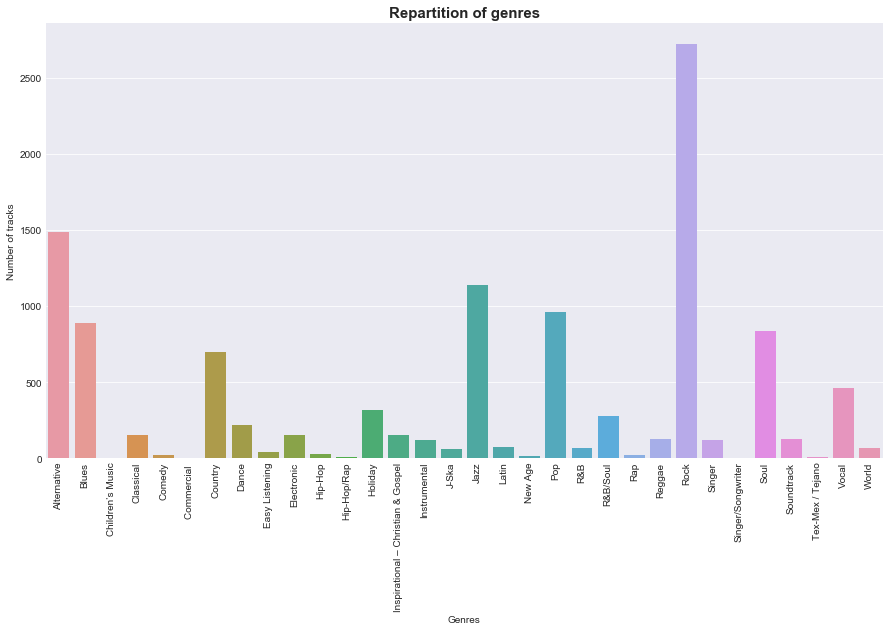

In [59]:
group_by_genre = tracks_with_tags.groupby(tracks_with_tags.genre).count()[['title']]
group_by_genre.columns = ["Number of tracks"]
group_by_genre["Genres"] = group_by_genre.index
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (15,8))
ax.set_title("Repartition of genres", fontsize=15, fontweight='bold')
sns.barplot(x="Genres", y="Number of tracks" , data=group_by_genre, saturation=0.7, errcolor='.7')
plt.xticks(rotation=90)
plt.show()

### 4.2  - Find the location

We first create dataframe of unique artists to later find their location by webscraping the SecondHandSong website.

In [4]:
artists = list(shs_df['name'])
unique_artists = pd.DataFrame(list(np.unique(artists)), columns = ["name"])

For each artist, we try to find its page on the SecondHandSong website and to find its country, if given. Some requests return multiple artists, so by formatting the string in order to avoid to miss a match, we then check the equality between the artist in our dataset and the results given by the requests. We handle manually some special cases that fail this method mostly due to special characters. If the artist page is not found we will return "Unavailable". If the artist page is found but its country is missing, we will return "Missing". This will help us to know if we can do more for a given artist or if the information is just not specified.

In [5]:
import unidecode
def format_string(x):
    return unidecode.unidecode(x).lower().replace("&", "and").replace("_", " ").replace("'", "").replace(".", "")

In [6]:
def get_artist_location(artist):
    artist = artist
    # Handle some special cases
    if artist == "98º":
        artist = "98 degrees"
    if artist == "4hero":
        artist = "4 hero"
    if artist == "? & The Mysterians":
        artist = "the mysterians"
    if artist == "crosby_ stills":
        artist = "crosby stills"
    r = requests.get('https://secondhandsongs.com/search?search_text='+format_string(artist))
    soup = BeautifulSoup(r.text, 'html.parser')
    if "Search" in (soup.find("head")).find("title").text:
        table = soup.find('section', id="section-artist")
        try :
            title = table.find('h2', id='t1')
        except:
            return "Unavailable"
        # Check if the result is an artist
        if "Artists" in title.text:
        # Get the artist ID to find the its web page on SHS
            # When only one artist is found
            if "1+" in title.text or title.text == "Artists 1":
                if "Mysterians" in artist:
                    print("mysterians 1+")
                artist_id = str(table.a).split("\"")[1]
            # When several artists are found
            else:
                if "Mysterians" in artist:
                    print("mysterians bug number results")
                artists = table.find_all("a")
                artist_id = ""
                for art in artists:
                    if art.text != "\n\n":
                        if format_string(artist) in format_string(art.text):
                            artist_id = str(art).split("\"")[1]
                            break
                if artist_id == "":
                    return "Unavailable"
    
            r_artist = requests.get('https://secondhandsongs.com'+artist_id)
            soup = BeautifulSoup(r_artist.text, 'html.parser')
        else:
            return "Unavailable"
    try:
        country = soup.find("dd", itemprop="nationality").text
        return country
    except:
        return "Missing"

In [7]:
#unique_artists["country"] = unique_artists["name"].map(lambda x : get_artist_location(x)) # executing the webscraping
#pickle.dump(unique_artists, open("data/first_location.p", "wb")) # saving the result as a pickle file
unique_artists = pickle.load(open("data/first_location.p", "rb"))

By looking at the artist for which we did not page on the SHS website, we observe that for a lot of them this is due to the fact that they are not single artists but featurings. We then decide to assign them the country of the first artist in the featuring. For those cases, we establish a list of separators that represent a featuring (e.g. "feat", "and", or "/", etc). Then we keep only the first artist in the list, and we proceed as before to find its country.

In [8]:
unknown_loc = unique_artists[unique_artists['country'] == "Unavailable"].reset_index()
unknown_loc.head(10)

,index,name,country
0,1,1 Giant Leap feat. Michael Stipe & Asha Bhosle,Unavailable
1,17,50 Cent ft. Young Buck,Unavailable
2,29,A*Teens,Unavailable
3,33,A3,Unavailable
4,50,Ace Karaoke Productions,Unavailable
5,63,Adema,Unavailable
6,94,Alabama 3 / Tenor Fly,Unavailable
7,113,Alexandra Burke Feat. Ne-Yo,Unavailable
8,125,Alison Krauss / Union Station,Unavailable
9,126,Alison Limerick,Unavailable


In [9]:
def location_featuring(artist):
    sep_list = ["with", ";", " ft. ", "feat", " and ", "/", "&"]
    sep = ""
    i = 0
    country = ""
    while (sep == "") and i < len(sep_list):
        if sep_list[i] in artist.lower():
            sep = sep_list[i]
            artist = artist.lower().split(sep)[0].replace("_", "")
            if artist[-1] == " ":
                artist = artist[:-1]
            country = get_artist_location(artist)
            break
        i = i+1
    if country == "":
        return "Unavailable"
    else:
        return country
                    
    

In [10]:
'''
# executing the second method to parse the featuring artists and find a country

feat_loc = unknown_loc[['name']]
feat_loc['country'] = feat_loc['name'].map(lambda x : location_featuring(x))
for n in feat_loc2['name']:
    i = unique_artists[unique_artists['name'] == n].index[0]
    if unique_artists.get_value(i, 'country') == "Unavailable":
        unique_artists.set_value(i, 'country', feat_loc2.get_value(feat_loc2[feat_loc2['name'] == n].index[0], 'country'))

pickle.dump(unique_artists, open("data/artists_location.p", "wb"))
'''

unique_artists = pickle.load(open("data/artists_location.p", "rb"))

We now merge these informations with our main dataframe containing all the tracks and their attributes, and check how many tracks don't have a country information.

In [15]:
#shs_df['country'] = shs_df['name'].map(lambda x : unique_artists.get_value(unique_artists[unique_artists['name'] == x].index[0], 'country'))
#pickle.dump(shs_df, open("data/covers_loc.p", "wb"))
shs_df = pickle.load(open("data/covers_loc.p", "rb"))
print("Number of tracks for which we didn't manage to webscrap the country : " + str(len(shs_df[shs_df['country'] == "Unavailable"])))
print("Number of tracks for which we country was missing on SHS : " + str(len(shs_df[shs_df['country'] == "Missing"])))

Number of tracks for which we didn't manage to webscrap the country : 457
Number of tracks for which we country was missing on SHS : 954


At the beginning of this project, we did a first location analysis using an additional provided by the Million Song dataset that contains a location for 30% or the artists. We then use this previous research of countries hoping we can match more artists among those for which we didn't manage to find a country.

In [101]:
artists_location = pickle.load(open("data/data_country.p", "rb"))
artists_location.head()

,shsID,trackID,artistID,shsPerf,artist,location,country
1,"115402,74782, Putty (In Your Hands)",TRNJXCO128F92E1930,ARQD13K1187B98E441,138584,Sylvie Vartan,"Iskretz, Bulgaria",Bulgaria
2,"24350, I.G.Y. (Album Version)",TRIBOIS128F9340B19,ARUVZYG1187B9B2809,24350,Donald Fagen,"Passaic, NJ",United States of America
7,"11012, Sheer Heart Attack",TRABVTG128F934AB80,AR9BVRM1187FB51139,97131,Hallows Eve,Georgia,Georgia
8,"11012, Sheer Heart Attack",TRRZZZZ128F422F784,ARNFBNR1187B9A25C2,-1,Helloween,"Hamburg, Germany",Germany
11,"10974, Standing At The Crossroads",TRNTRUC128F4234EB5,AR49MOS1187B991A8B,139493,Smokey Wilson,"Glen Allen, MS",United States of America


In order to merge the two dataframe, we add the column 'artist_id' in our dataframe of unique artists, extract from our main dataframe.

In [18]:
unique_artists['id'] = unique_artists['name'].map\
(lambda x : shs_df.get_value(shs_df[shs_df['name'] == x].head(1).index[0], 'artistID'))

We then define the function below to try to find the missing informations in our unique artists dataframe into our location artist dataframe. Since we separated the "Unavailable" from the "Missing", we first exectue the function for all artists for which the country is "Missing", and then for all artists for which the country is "Unavailable".

In [50]:
def complete_location(value):
    for a_id in unique_artists[unique_artists['country'] == value]['id']:
        if not artists_location[artists_location['artistID'] == a_id].empty:
            index_unique_art = unique_artists[unique_artists['id'] == a_id].index[0]
            index_art_loc = artists_location[artists_location['artistID'] == a_id].index[0]
            country = artists_location.get_value(index_art_loc, 'country')
            unique_artists.set_value(index_unique_art, 'country', country)
            

complete_location("Missing")
complete_location("Unavailable")

In [51]:
print("Number of artists for which we didn't manage to webscrap the country : " + str(len(unique_artists[unique_artists['country'] == "Unavailable"])))
print("Number of artists for which we country was missing on SHS : " + str(len(unique_artists[unique_artists['country'] == "Missing"])))

Number of artists for which we didn't manage to webscrap the country : 159
Number of artists for which we country was missing on SHS : 404


In [104]:
#shs_df['country'] = shs_df['name'].map(lambda x : unique_artists.get_value(unique_artists[unique_artists['name'] == x].index[0], 'country'))
#pickle.dump(shs_df, open("data/covers_loc.p", "wb"))
shs_df = pickle.load(open("data/covers_loc.p", "rb"))

print("Number of tracks for which we didn't manage to webscrap the country : " + str(len(shs_df[shs_df['country'] == "Unavailable"])))
print("Number of tracks for which we country was missing on SHS : " + str(len(shs_df[shs_df['country'] == "Missing"])))

Number of tracks for which we didn't manage to webscrap the country : 310
Number of tracks for which we country was missing on SHS : 684


Finally, we managed to find a country for 417 tracks using this additional file. Less than 1'000 on 18'000 (~ 5%) tracks have an unknown location.

In [ ]:
# load the files
artist_location = pickle.load(open("artists_location.p", "rb"))
genres = pickle.load(open("data/genre_covers.p", "rb"))
# Add the genres and the artist location to the covers dataframe
covers=covers.merge(artist_location,how='left',left_on='name',right_on='name')
covers=covers.merge(genres[['genre']],how='left',left_on='trackID',right_index=True)

In [ ]:
# Drop useless columns
covers.drop(['original_shsPerf','original_id','first_algo_result','second_algo_result','artist'],axis=1,inplace=True)
covers.rename(columns = {'name':'artist','final_original':'status'}, inplace = True)

In [ ]:
# Create multilevel index with clique_id and track_id
covers.set_index(['clique_id','trackID'],inplace=True)

### 4.3. Determine artist location for spatial analysis

In [ ]:
#Load Additional files
#unique_artists=pd.read_csv('data/AdditionalFiles/unique_artists.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['artistID','artistMID','randomTrack','name'])
unique_artists=pd.read_csv('data/AdditionalFiles/unique_artists.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['artistID','artistMID','randomTrack','name'])
artist_location=pd.read_csv('data/AdditionalFiles/artist_location.txt',delimiter='<SEP>',engine='python',header=None,index_col=0,names=['artistID','lat','long','name','location'])
artist_location.head()

We now load a subset of Second Hand Song

In [ ]:
def read_shs_files(pathToFile):
    f = open(pathToFile)
    s = StringIO()
    cur_ID = None
    for ln in f:
        if not ln.strip():
                continue
        if ln.startswith('%'):
                cur_ID = ln.replace('\n','<SEP>',1)
                continue
        if cur_ID is None:
                print ('NO ID found')
                sys.exit(1)
        s.write(cur_ID + ln)
    s.seek(0)
    df = pd.read_csv(s,delimiter='<SEP>',engine='python',header=None,names=['shsID','trackID','artistID','shsPerf'])
    return df[['trackID', 'artistID', 'shsPerf']]

We retrieve the artists' names using the unique_artists.txt file and we assign a location for each track using the artist_location.txt.

In [ ]:
def get_location(x) : 
    if x in artist_location.index:
        return artist_location.get_value(x, 'location')
    else : 
        return np.nan
    
data=read_shs_files('data/SHS_testset.txt')
data['artist'] = data['artistID'].map(lambda x : unique_artists.get_value(x, 'name'))
data['location'] = data['artistID'].map(lambda x : get_location(x))
data.head()

We now create the function finding the country for each location. In order to do that we wille use three different python packages : pycountry, us, and geopy, as geopy.geocoders does not support too much requests. 

- First, we will use the pycountry package to extract countries if location contains one. 


- If we didn't match any country in pycountry, we will use the us package to check if a us state is present in the location. From the data, we have observed that if the location refer to a us state, the location is either only defined by the state, or the state is the last element of the location.


- If the two precedent methods does not succeed, we will use the geopy.geocoders package, using Nominatim( ).


- We will manually define countries for some location as they are sometimes mispelled, troncated or refer to a website link.

In [ ]:
geolocator = Nominatim()

def get_country(x):
    if x == np.nan:
        return x
    x = x.replace("-", ",")
    for c in pycountry.countries:
        if "England" in x or "UK" in x: 
            return "United Kingdom"
        elif c.name.lower() in x.lower():
            return c.name
    refactorlast = x.split(",")[-1].replace(" ", "")
    refactorfirst = x.split(",")[0]
    usstatelast = us.states.lookup(refactorlast)
    usstatefirst = us.states.lookup(refactorfirst)
    if usstatelast != None or usstatefirst != None:
        return "United State of America"
    elif x == "Swingtown":
        return "United State of America"
    elif x == "<a href=\"http://billyidol.net\" onmousedown='UntrustedLink.bootstrap($(this), \"fc44f8f60d13ab68c56b3c6709c6d670\", event)' target=\"_blank\" rel=\"nofollow\">http://billyidol.net</a>":
        return "United Kingdom"
    elif x == "Lennox Castle, Glasgow" or x == "Knowle West, Bristol, Avon, Engla"\
        or x == "Goldsmith's College, Lewisham, Lo" or x == "Julian Lennon&#039;s Official Facebook Music Page"\
        or x == "Sydney, Moscow, Pressburg" or x == "Penarth, Wales to Los Angeles" or x == "Leicester, Leicestershire, Englan":
        return "United Kingdom"
    elif x == "Vancouver, British Columbia, Cana":
        return "Canada"
    elif x == "Washington DC" or x == "Philladelphia" or "New Jersey" in x:
        return "United State of America"
    elif "Czechoslovakia" in x :
        return "Česko"
    elif x == "Jaded Heart Town":
        return "Germany"
    elif x == "RU" or x == "Russia":
        return "Russia"
    else :
        location = geolocator.geocode(x, timeout=None)
        return location.address.split(",")[-1]

In [ ]:
#data['country'] = data['location'].map(lambda x : get_country(x))

The only problem with geopy is that it returns a country in its native language. To uniform our data, we create a function that translates manually the countries in English.

In [ ]:
def rename(x):
    if "België - Belgique - Belgien" in x:
        return "Belgium"
    elif "Brasil" in x:
        return "Brazil"
    elif "United State" in x:
        return "United States of America"
    elif "Italia" in x:
        return "Italy"
    elif "Norge" in x:
        return "Norway"
    elif "España" in x:
        return "Spain"
    elif "Nederland" in x :
        return "Netherlands"
    elif "Suomi" in x :
        return "Finland"
    elif "Sverige" in x :
        return "Sweden"
    elif "UK" in x :
        return "United Kingdom"
    elif x[0] == " ":
        return x[1:]
    else : 
        return x

In [ ]:
#data['country'] = data['country'].map(lambda x : rename(x))
#pickle.dump(data, open( "data.p", "wb" ) )
data_country = pickle.load(open("data/data_country.p", "rb"))

In [ ]:
data_country.head()

### 4.4. Addition of the genre for each track (Use of LastFM dataset and external website for genre listing)

To find the genre of a song, we will use the LastFM dataset that contains a list a tags for each song.
Since the dataset is from the MillionSongDataset, we will not use all of the available tracks from LastFM but, but only the ones contained in the SecondHandSong dataset.

In [ ]:
# Loading the files if they are in the SecondHandSong dataset and create the dataframe
covers_df = pickle.load(open("data/covers.p","rb"))
list_tracks = covers_df.trackID
test_path = "../../lastfm_test"
train_path = "../../lastfm_train"

genre_df = pd.DataFrame()
def create_dataFrame(genre_df):
    for track in list_tracks:
        folder1 = track[2]
        folder2 = track[3]
        folder3 = track[4]
        folder_path = "/" + folder1 + "/" + folder2 + "/" + folder3 + "/"
        track_path = folder_path + track + ".json"
        if glob.glob(train_path + track_path) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(train_path + track_path)), orient="index").transpose())
        elif glob.glob(test_path + folder_path + track) != []:
                genre_df = genre_df.append(pd.DataFrame.from_dict(json.load(open(test_path + track_path)), orient="index").transpose())
    genre_df = genre_df.reset_index()
    return genre_df

#tracks_with_tags = create_dataFrame(genre_df)
tracks_with_tags = pickle.load(open("tracks_with_tags", "rb"))

We now list the unique tags in the resulting dataframe. Due to a time limit for the computation of the matching, we will first test on a subset.

In [ ]:
tags = list()
for i in range (0,1000):
    tags = tags + tracks_with_tags.tags[i]
    
tags = np.unique(tags).tolist()

A lot of tags contains useless information, thus we first proceed to a pre-cleaning.

In [ ]:
clean_tags = {}
def clean_tag(x):
    clean = x.replace("ooo", "")
    clean = clean.replace("-o", "")
    clean = clean.replace("o-", "")
    clean = clean.replace("- ", "")
    clean = clean.replace("-", "")
    clean_tags[x] = clean
for t in tags:
    clean_tag(t)

In order assign a genre to each song, we will use their different tags and try to match it with a list of genre obtained by webscrapping the http://www.musicgenreslist.com website. For more details on the webscrapping see the notebook Genre Webscrapping.ipynb.

In [ ]:
map_genres = pickle.load(open("data/map_genres", "rb"))
all_genres = pickle.load(open("data/all_genres.p", "rb"))

We then use the Sequence Matcher package to match tags to the web-scrapped genres.

In [ ]:
threshold = 0.80
def match_genres():
    i = 0
    genre_map = {}
    no_match = list()
    for ind in range(0,len(tags)):
        name1 = tags[ind]
        if i%1000 == 0:
            print(i)
        if clean_tags[name1] == "":
            genre_map[name1] = np.nan
        best_ratio = 0
        match = ""
        for name2 in map_genres.keys():
            if name2.lower() in name1.lower():
                for subgenre in map_genres[name2]:
                    ratio = SequenceMatcher(None,name1.lower(),name2.lower()).ratio()
                    if ratio > best_ratio:       # we find the maximum similarity
                        best_ratio = ratio
                        match = name2
                if (best_ratio > threshold):     # if it's superior to our threshold we add that couple to the mapping
                    genre_map[name1] = match
                else:
                    genre_map[name1] = name2
        if match == "":
            for subgenre in all_genres:
                ratio = SequenceMatcher(None,name1.lower(),name2.lower()).ratio()
                if ratio > best_ratio:       # we find the maximum similarity
                    best_ratio = ratio
                    match = name2
            if (best_ratio > threshold):     # if it's superior to our threshold we add that couple to the mapping
                genre_map[name1] = match
            else :
                genre_map[name1] = np.nan
        i = i+1
    return (genre_map, no_match)

<a id='part5'></a>
## 5. Access to cluster files to retrieve tempo and popularity

#### Milestone 2

We open the first file of the subset, to check what the HDF5 keys are and then we read each of them.

In [7]:
with pd.HDFStore("data/MillionSongSubset/data/A/A/A/TRAAAAW128F429D538.h5") as hdf:
    print(hdf.keys())

['/analysis/songs', '/metadata/songs', '/musicbrainz/songs']


In [40]:
pd.read_hdf("data/MillionSongSubset/data/A/A/A/TRAAAAW128F429D538.h5","/analysis/songs")

,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,idx_bars_confidence,idx_bars_start,idx_beats_confidence,idx_beats_start,...,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
0,22050,a222795e07cd65b7a530f1346f520649,0.0,218.93179,0.247,0.0,0,0,0,0,...,1,0.736,-11.197,0,0.636,218.932,92.198,4,0.778,TRAAAAW128F429D538


In [21]:
pd.read_hdf("data/MillionSongSubset/data/A/A/A/TRAAAAW128F429D538.h5","/metadata/songs")

,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,,165270,0.581794,0.401998,ARD7TVE1187B99BFB1,NaN,California - LA,NaN,e77e51a5-4761-45b3-9847-2051f811e366,Casual,4479,,0,0,Fear Itself,300848,0.60212,SOMZWCG12A8C13C480,I Didn't Mean To,3401791


In [22]:
pd.read_hdf("data/MillionSongSubset/data/A/A/A/TRAAAAW128F429D538.h5","/musicbrainz/songs")

,idx_artist_mbtags,year
0,0,0


We only need to extract <tt>tempo</tt> and <tt>song_hotttnesss</tt>, here is an example of how to do that on the subset :

In [66]:
tempo = []
hotness = []

files = glob.glob("data/MillionSongSubset/data/A" + "/[A-Z]/[A-Z]/*")
for f in files:
    tempo.append(pd.read_hdf(f,"/analysis/songs")["tempo"][0])
    hotness.append(pd.read_hdf(f,"/metadata/songs")["song_hotttnesss"][0])

In [67]:
tempo = np.asarray(tempo)
hotness = np.asarray(hotness)
print(tempo)
print(hotness)

[ 124.059   80.084   54.874 ...,   96.064  149.012  162.653]
[ 0.54795294  0.47563847         nan ...,         nan         nan  0.270776  ]


In [71]:
print("Number of tracks =", len(files))
print("with missing hotness values =", np.sum(np.isnan(hotness)))

Number of files = 7620
with missing hotness values = 3268


We already got 3268 unknown hotness values and we only tested on a subset of 7620 song, so we can expect to have that information for only a little over half of our final dataset. Maybe we won't use it.

In [64]:
#loading of the dataframe
covers = pickle.load(open("data/covers.p","rb"))
covers

,trackID,artistID,shsPerf,clique_id,name,title,year
0,TRGDMZP128F42BC52B,ARB1DDF1187FB4FCFB,-1,0,Louis Armstrong,Stardust,1988.0
1,TRCATYW12903D038FE,ARGJEEO1271F573FD6,-1,0,Artie Shaw and his orchestra,Stardust,1988.0
2,TRVMZJZ128F4270CE4,ARY0HTV1187FB4A1B1,-1,0,Hoagy Carmichael,Star Dust,1999.0
3,TRKOINL128F42926C3,ARQ5FSZ1187B98AD74,-1,0,Connee Boswell & Sy Oliver Orchestra,Star Dust,NaN
4,TROJZTF128F428B546,ARJN76O1187FB43C99,-1,1,Ana Belén,Yo Vengo A Ofrecer Mi Corazon,2001.0
5,TRYQEDQ128F427917C,ARS4KT21187B9B9438,-1,1,Fito Paez,Yo Vengo A Ofrecer Mi Corazon,NaN
6,TRCKNGE128F92DA3F3,AR1CB5G1187B9AFB8E,-1,2,Electric Light Orchestra,Mr. Blue Sky,1977.0
7,TRIOPLY128F423CFF3,ARKZJ301187FB521B2,-1,2,Lily Allen,Mr Blue Sky,2007.0
8,TRWNDEU128F9329BF7,ARVZWQ31187B9B8946,-1,3,Liars,Mr Your On Fire Mr,2002.0
9,TRYOPHS128F146DEFD,AR6NYHH1187B9BA128,-1,3,Yeah Yeah Yeahs,Mr. You're On Fire Mr.,2003.0


Once all the files are accessible on the cluster, we will have to go through our SHS dataset and get those attributes for each track_id.
We will do so in the following way : (the paths are just examples on the subset)

In [72]:
tempo = []
hotness = []

for track in covers["trackID"]:
    folder1 = track[2]
    folder2 = track[3]
    folder3 = track[4]
    folder_path = "data/MillionSongSubset/data/" + folder1 + "/" + folder2 + "/" + folder3 + "/"
    track_path = folder_path + track + ".h5"
    if Path(track_path).exists(): #to delete later
        tempo.append(pd.read_hdf(track_path,"/analysis/songs")["tempo"][0])
        hotness.append(pd.read_hdf(track_path,"/metadata/songs")["song_hotttnesss"][0])

In [73]:
print(len(tempo))
print(np.sum(~np.isnan(hotness)))

204
128


Unsurprisingly, we only found 204 of those tracks in the subset and 128 of them have a hotness value.

#### Milestone 3

Using the script *get_data_cluster.py*, we retrieved a csv file which contains the informations we fetched on the cluster : the "tempo" and "song_hotttness" attributes of each track in our cover dataset.

In [181]:
full_df = pd.read_csv("data/tempo_and_popularity.csv")

In [182]:
full_df

,track_id,song_hotttnesss,tempo
0,TRCKNGE128F92DA3F3,nan,92.195
1,TRIOPLY128F423CFF3,0.634538103814,88.602
2,TRWNDEU128F9329BF7,0.725213133131,140.600
3,TRYOPHS128F146DEFD,0.661648170034,80.917
4,TRQNZCE128E078A9C0,0.450762241641,120.327
5,TRMBSQR128F92DF66E,nan,103.189
6,TREVWUZ128F4263A9B,nan,113.973
7,TRGYREY128E0791913,0.540009276927,109.904
8,TRBLBSR128F425EBFE,nan,92.555
9,TRLRWJK128F427D602,nan,96.855


Please note that this dataframe contains "only" 16221 tracks out of our 17541, because all the dataset files have not been unzipped and thus are not accessible.

In [194]:
full_df[full_df.song_hotttnesss.str.contains("nan")]=np.nan

In [213]:
#percentage of song_hotttnesss available
valid_hotness = full_df[full_df.song_hotttnesss.notnull()].song_hotttnesss.astype(float)
100 * ( 1 - (valid_hotness==0.0).sum() / covers.shape[0] )

93.700473177127876

In [214]:
#percentage of tempo available
100 * ( 1 - (full_df.tempo==0).sum() / covers.shape[0] )

99.988598141497064

In [187]:
#Number of matches between the full set and the cover set (all of them are a match)
len(set(full_df.track_id) & set(covers.trackID))

16221

<a id='part6'></a>
## 6. Data Analysis

In [381]:
df = pickle.load(open("covers_FINAL.p","rb"))
df

artistID shsPerf  \
clique_id trackID                                          
2         TRCKNGE128F92DA3F3  AR1CB5G1187B9AFB8E   16660   
          TRIOPLY128F423CFF3  ARKZJ301187FB521B2  551633   
3         TRWNDEU128F9329BF7  ARVZWQ31187B9B8946  354066   
          TRYOPHS128F146DEFD  AR6NYHH1187B9BA128  354067   
4         TRQNZCE128E078A9C0  ARWILYB1187FB37DFE   52011   
          TRMBSQR128F92DF66E  ARPI2DX1187FB4CED4   52010   
6         TREVWUZ128F4263A9B  AR9UYPT1187B9AE833   45769   
          TRGYREY128E0791913  ARQ294N1187FB53D2A    9133   
7         TRBLBSR128F425EBFE  AR36FFP1187B9926D7   59663   
          TRLRWJK128F427D602  AR6NBDC1187FB4D96D     575   
          TRHFEEP12903CD3863  ARGYRE31187FB515A2   28082   
          TRWDJFG12903C94C9E  AR5ZI3K1187FB38BE0  150458   
          TRLQSWL128F932C80B  AR8JQ521187FB491AA   86557   
8         TRZWJEP128F92F3178  ARUL9Y61187FB3DF6B   68280   
          TRHFJNY128F428FC4B  AR5FP401187FB523C9   68275   
          TRMNZOQ128F426254A  AR9YR2T1187FB3E9EE   69922   
          TRYEKWE128F1459C42  AR6AK6B1187FB48EDD   68273   
          TRPTALT128F426F99F  ARQRDXP1187B98B9E6  305654   
9         TRQPBQV128F423C1E9  AREH7LP1187B9B7164   14943   
          TRTTEXX128F428BE1D  ARJVH1S1187FB378C3       0   
          TRYXXWR12903CA7191  ARMBTFC1187FB56343  160334   
10        TRVXQXV128F427863A  ARTO3L81187B9ACA8C   21513   
          TRZJWSX12903CA89C1  ARC1IHZ1187FB4E920   21514   
11        TREVQFK128F4267577  ARTQ8QP1187FB3D220   31718   
          TRFWVIP128EF3444F3  ARE66XI1187B9B8743   31719   
12        TRXZEBD128F4268BDB  AR33KSV1187FB4B900   88882   
          TRBZYQA128F9359288  AR20SBM1187B9966A7   88880   
13        TRTLSVW12903CFB4F5  ARWX5TK1187FB4CDBE   29876   
          TRJLBUB128F92E293E  ARN3SEQ1187FB47AA8  152956   
14        TRCNOGX128F92E9A8D  ARVODWZ1187B99E831       0   
...                                          ...     ...   
5842      TRDTJZI128EF34E78F  AR1BI4V1187B9937A9  184203   
          TRJUXRE128F92F88D4  ARHSO041187FB3D06D   33329   
          TRKFNUK128F428A62D  ARV3CRH1187B9A1B21   14338   
5843      TROWHKP12903CCC703  ARCGI111187B9B8B99   67211   
          TRELXLZ12903CB9DC5  ARYDLXP122988F049E   62368   
5844      TRPMGHH128E07917AC  ARF4L041187FB4D318   99651   
          TRMTFOJ12903CAFF57  AR3KVH41187FB3F71F   99652   
5845      TRUAXLK12903CD39B5  AREYJKQ1187B9AEAB5  104087   
          TRNNQSH128F4245865  AR4SL791187B9890BF       0   
          TRTWMBY128F9307A6D  ARSX6IX1187B9B640C   99655   
5846      TRITRRU128F423DC76  ARJ59K61187FB5B43E   99662   
          TRRCCUQ128F42449F7  ARNUU2R1187B9A316C   99675   
5847      TRCEMLE128F4281036  ARJ59K61187FB5B43E   99668   
          TRCGGYF128F9338B93  ARYDZKJ1187FB540C6   99680   
5848      TRAHFYD128F426BBAD  AR94ZOI1187FB46BDA  103980   
          TRRUFPY128F4261744  ARJWDFW1241B9C69AE  118487   
5849      TRTFWRF128F92E378E  ARX1CYE1187FB3A97B   99730   
          TRBXSHQ128F4278320  ARLM6I41187B9BA123   99731   
          TRGOMBU128F42895B9  AR14CJ91187FB3A994   99733   
5850      TRMCRMX128F4267AC3  ARSPUHE1187B99DB8A  125607   
          TRNBSWN128F1473B31  ARLG9UJ1187B9B6C67   24567   
5851      TRWAULS128F1474CBF  AR7GM0K1187B9B74B4   20304   
          TRZVRJL128F92E2984  ARDYR3C1187FB461CE    9982   
          TRMQPSQ128F426C548  ARAWPR61187B9B5A4C    9981   
5852      TRUZAVE128F426E391  AR3DLBB1187B98F3DF  106651   
          TRDNIRY128F425A5C8  ARDRJSP126E2B3BEF8  248918   
          TRSDUWY128F92DD39A  ARR176H1187FB4CDFE   99838   
          TRPVDKP128F934956E  ARELPXQ1187FB384FD  138704   
5853      TREMVLC128F92EFA95  ARBFDJW1187B9AD27A   29576   
          TRMTMWV128F92F6F78  ARDYR3C1187FB461CE    9986   

                                                            artist  \
clique_id trackID                                                    
2         TRCKNGE128F92DA3F3              Electric Light Orchestra   
          TRIOPLY128F423CFF3                     

### 6.1 General Stats

Song most covered (biggest clique) :

In [17]:
clique_size = df.groupby("clique_id").size()

In [18]:
# Size of the clique
clique_size.max()

43

In [19]:
# ID of the clique
clique_size.idxmax()

4003

In [22]:
df.loc[4003]

,artistID,shsPerf,artist,title,language,date,country,genre,year,rank,status
trackID,,,,,,,,,,,
TREETFR128F423716B,ARK84KY1187FB4599A,126761,Keren Ann,Silent Night,English,2007,France,NaN,2007,21,cover
TRRDRSQ128F93226FF,AR633SY1187B9AC3B9,87764,Weezer,Silent Night,English,"December 16, 2008",United States,Holiday,2008,22,cover
TREMRMH128F932EA5F,ARS23GQ1187FB4F71A,84630,Ledisi,Silent Night,English,"September 23, 2008",United States,Soul,2008,22,cover
TRGURDV128F92E2538,ARRI65G1187FB5992E,109982,Straight No Chaser,Silent Night (Album Version),English,"October 28, 2008",United States,NaN,2008,22,cover
TRKMGRG128F92EB224,ARL7YU61187B9B85D7,117344,G4 feat. Sir Cliff Richard,Silent Night,English,"November 27, 2006",United Kingdom,Holiday,2006,20,cover
TRYHNAJ128F4228921,ARJ47041187B98E500,150775,Liederjan,Silent Night,English,"October 18, 2007",NaN,Holiday,2007,21,cover
TRIVFFA128F425EA50,ARK36B71187FB589D2,111777,Paul Potts,Silent Night,English,2007,United Kingdom,Holiday,2007,21,cover
TRNFREP128F9333FC1,AR6OSQ81187FB3FDAB,109758,Ronan Keating,Silent Night,English,"November 13, 2009",Ireland,NaN,2009,23,cover
TRRVQSF128F9302888,AROMLCI1187FB4C6E7,112428,Sarah Brightman & José Carreras,Silent Night,English,"October 29, 2008",United Kingdom,NaN,2008,22,cover


*Silent Night* is the most covered song.

What about the <b>top 10</b> :

In [56]:
top10_songs = clique_size.sort_values(ascending=False)[:10].keys().tolist()

In [232]:
top10_songs_nb = clique_size.sort_values(ascending=False)[:10].values-1

In [294]:
print("       TOP 10 SONGS")
print("=========================")
for i,clique in enumerate(top10_songs):
    original = df.loc[clique][df.loc[clique].status=="original"]
    print(str(i+1)+".", original.title[0]+",",original.year[0]+",", original.artist[0]+",", top10_songs_nb[i])

       TOP 10 SONGS
1. Silent Night, 1961, Chet Atkins, 42
2. White Christmas, 1942, Bing Crosby, 36
3. Unchained Melody, 1955, Les Baxter, 25
4. O Holy Night, 1958, Tennessee Ernie Ford, 24
5. Georgia On My Mind, 1930, Hoagy Carmichael, 22
6. I'll Be Home For Christmas, 1943, Bing Crosby, 21
7. The Christmas Song, 1946, Nat King Cole, 20
8. Have Yourself A Merry Little Christmas, 1967, Barbra Streisand;Yves Montand, 20
9. Over The Rainbow, 1939, Judy Garland, 18
10. The Way You Look Tonight, 1936, Fred Astaire and Ginger Rogers, 17


In [78]:
artists_sorted = df[df.status=="original"].groupby("artist").size().sort_values(ascending=False)

In [79]:
top10_artists = artists_sorted[:10].keys().tolist()

In [227]:
top10_artists_nb = artists_sorted[:10].values-1

In [231]:
print("       TOP 10 ARTISTS")
print("=========================")
for i,artist in enumerate(top10_artists):
    print(str(i+1)+".", artist + ",", top10_artists_nb[i])

       TOP 10 ARTISTS
1. Bob Dylan, 37
2. The Velvet Underground, 25
3. The Rolling Stones, 22
4. Led Zeppelin, 22
5. Kiss, 22
6. Pink Floyd, 20
7. Metallica, 20
8. Chuck Berry, 19
9. Marvin Gaye, 19
10. Radiohead, 18


### 6.2 Date

Let's find the different top 10 by decades :

In [181]:
df_valid_year = df[df.year.notnull()]

In [165]:
df_valid_year.groupby((df_valid_year.year.astype(int)//10)*10).count()

,artistID,shsPerf,artist,title,language,date,country,genre,year,rank,status
year,,,,,,,,,,,
1910,1,1,1,1,1,1,1,1,1,1,1
1920,49,49,49,49,49,49,45,36,49,49,49
1930,116,116,116,116,116,116,110,79,116,116,116
1940,167,167,167,167,167,167,158,87,167,167,167
1950,1091,1091,1091,1091,1091,1091,1045,623,1091,1091,1091
1960,3028,3028,3028,3028,3028,3028,2863,1790,3028,3028,3028
1970,2728,2728,2728,2728,2728,2728,2538,1856,2728,2728,2728
1980,2158,2158,2158,2158,2158,2158,2026,1458,2158,2158,2158
1990,3107,3107,3107,3107,3107,3107,2829,1919,3107,3107,3107


In [293]:
top10_per_decade = []

for decade in range(1920,2001,10):
    cliques_decade = df_valid_year[(df_valid_year.status == "original") & ((df_valid_year.year.astype(int)//10)*10 == decade)]
    id_cliques_decade = cliques_decade.index.get_level_values(0).tolist()
    top_clique_decade = clique_size[id_cliques_decade].sort_values(ascending=False)[:10].keys().tolist()
    top10 = []
    for clique in top_clique_decade:
        original = df.loc[clique][df.loc[clique].status=="original"]
        top10.append(original.title[0]+", "+original.year[0]+", "+original.artist[0]+", "+str(clique_size[clique]))
    top10_per_decade.append(top10)

print("     TOP 10 SONGS BY DECADES")
print("==================================")
for i,top in enumerate(top10_per_decade):
    print(" ",1920+i*10)
    print("---------")
    for j,song in enumerate(top):
        print(str(j+1)+".", song)

     TOP 10 SONGS BY DECADES
  1920
---------
1. Trouble In Mind, 1926, Bertha "Chippie" Hill, 13
2. Sweet Georgia Brown, 1925, The California Ramblers, 12
3. How Long How Long, 1928, Blind Lemon Jefferson, 9
4. Pony Blues, 1929, Charley Patton, 8
5. Ain't Misbehavin', 1929, Louis Armstrong, 8
6. Statesboro Blues, 1929, Blind Willie Mctell & The Regal Country Blues, 7
7. He's In The Jailhouse Now, 1927, Blind Blake, 5
8. See That My Grave Is Kept Clean, 1928, Blind Lemon Jefferson, 5
9. Mother's Children Have A Hard Time, 1928, Blind Willie Johnson, 5
10. Match Box Blues (4424), 1927, Blind Lemon Jefferson, 4
  1930
---------
1. Over The Rainbow, 1939, Judy Garland, 19
2. The Way You Look Tonight, 1936, Fred Astaire and Ginger Rogers, 18
3. Strange Fruit, 1939, Billie Holiday, 12
4. The Very Thought Of You, 1938, Billie Holiday, 12
5. Night and Day, 1932, Fred Astaire and Ginger Rogers, 10
6. As Time Goes By, 1931, Rudy Vallée, 10
7. They Can't Take That Away From Me, 1937, Fred Astair

Nb of covers of original from a certain year :

In [279]:
covers_per_original_year = []

for couple_years in range(1920,2011,2):
    originals_by_year = df_valid_year[(df_valid_year.status == "original") & ((df_valid_year.year.astype(int)//2)*2 == couple_years)]
    id_cliques_original = originals_by_year.index.get_level_values(0).tolist()
    nb_covers = clique_size[id_cliques_original].sum()
    covers_per_original_year.append(nb_covers)

covers_per_original_year

[0, 3, 20, 39, 93, 74, 40, 62, 105, 109, 130, 96, 82, 142, 151, 205, 288, 464, 939, 713, 590, 709, 1074, 1370, 995, 995, 758, 556, 538, 698, 640, 525, 473, 417, 400, 317, 304, 386, 288, 201, 185, 215, 163, 132, 48, 0]


<Container object of 46 artists>

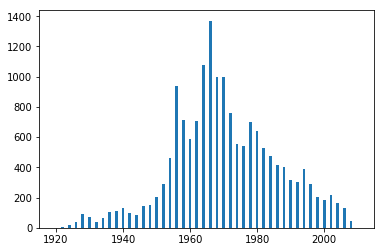

In [354]:
plt.bar(range(1920,2011,2),covers_per_original_year)

* General stat :

In [360]:
same_decade = 0

for id_clique, clique in df_valid_year.groupby(level=0):
    if ((clique.status=="original").sum() < 1) | ((clique.status=="cover").sum() < 1):
        continue
    og_year = clique[clique.status=="original"].year.astype(int)[0]
    same_decade += ((clique.status=="cover") & (clique.year.astype(int)-og_year < 10)).sum()
    
print(same_decade)

3611


In [361]:
print("Percentage of covers recorded more than 10 years after the original song :", 100*(1-same_decade/df.shape[0]), "%")

Percentage of covers recorded more than 10 years after the original song : 79.4139444729 %


### 6.3 Country

* Repartition :

In [373]:
all_originals = df_valid_country[df_valid_country.status=="original"]
all_covers = df_valid_country[df_valid_country.status=="cover"]

In [376]:
pickle.dump(all_originals.groupby("country").size(),open("data/originals_per_country.p","wb"))
all_originals.groupby("country").size()

country
Algeria                   1
Argentina                 2
Australia                47
Austria                   3
Barbados                  3
Belgium                   9
Benin                     1
Brazil                   32
Canada                  131
Chile                     2
Colombia                  1
Cuba                      2
Denmark                   5
Finland                   6
France                   48
Germany                  55
Greece                    2
Iceland                   7
Indonesia                 1
Ireland                  51
Italy                    48
Jamaica                  36
Japan                     3
Mexico                    6
Netherlands               7
New Zealand               5
Norway                   12
Pakistan                  1
Poland                    1
Portugal                  1
South Africa              3
Spain                     6
Sweden                   44
Switzerland               6
Trinidad and Tobago       1
United Kingd

In [377]:
pickle.dump(all_covers.groupby("country").size(),open("data/covers_per_country.p","wb"))
all_covers.groupby("country").size()

country
Argentina               12
Australia              135
Austria                  2
Belgium                 50
Bermuda                  2
Brazil                  78
Cameroon                 1
Canada                 340
Croatia                  1
Cuba                     5
Czech Republic           1
Denmark                 20
Dominican Republic       3
Finland                102
France                 179
Georgia                  6
Germany                143
Greece                  16
Guinea                   1
Iceland                  5
Indonesia                1
Ireland                113
Israel                   5
Italy                  126
Jamaica                 79
Japan                   11
Mexico                  15
Netherlands             72
New Zealand              3
Norway                  51
Panama                   2
Poland                  14
Portugal                 3
Russian Federation       1
Réunion                  1
Senegal                  2
Slovenia            

* General stat :

In [290]:
df_valid_country = df[df.country.notnull()]

In [366]:
same_country = 0

for id_clique, clique in df_valid_country.groupby(level=0):
    if ((clique.status=="original").sum() < 1) | ((clique.status=="cover").sum() < 1):
        continue
    og_country = clique[clique.status=="original"].country[0]
    same_country += clique[clique.status=="cover"].country.str.count(og_country).sum()

print(same_country)

6104


In [367]:
print("Percentage of covers from a different country than the original song :", 100*(1-same_country/df.shape[0]), "%")

Percentage of covers from a different country than the original song : 65.201527849 %


You can find the code used to generate the map from the article in the notebook *Location.ipynb*.

### 6.4 Genre

* Repartition :

In [356]:
df_valid_genre = df[df.genre.notnull()]

In [401]:
all_originals = df_valid_genre[df_valid_genre.status=="original"]
all_covers = df_valid_genre[df_valid_genre.status=="cover"]

In [402]:
all_originals.groupby("genre").size()

genre
Alternative                            670
Blues                                  289
Children’s Music                         1
Classical                               36
Comedy                                   5
Commercial                               1
Country                                266
Dance                                   44
Easy Listening                          13
Electronic                              48
Hip-Hop                                 23
Hip-Hop/Rap                              1
Holiday                                 52
Inspirational – Christian & Gospel      38
Instrumental                            27
J-Ska                                   14
Jazz                                   219
Latin                                   22
New Age                                  2
Pop                                    391
R&B                                     27
R&B/Soul                               137
Rap                                      6
Regga

In [403]:
all_covers.groupby("genre").size()

genre
Alternative                            765
Blues                                  553
Children’s Music                         1
Classical                              112
Comedy                                  19
Country                                408
Dance                                  165
Easy Listening                          28
Electronic                             101
Hip-Hop                                  6
Hip-Hop/Rap                              3
Holiday                                266
Inspirational – Christian & Gospel     110
Instrumental                            88
J-Ska                                   47
Jazz                                   848
Latin                                   47
New Age                                  9
Pop                                    552
R&B                                     36
R&B/Soul                               133
Rap                                     11
Reggae                                  90
Rock 

In [404]:
original_genres = all_originals.groupby("genre").size()
original_genres.set_value("Other",original_genres.sort_values(ascending=False)[9:].sum())
top10_original_genres = original_genres.sort_values(ascending=False)[:10]
pickle.dump(top10_original_genres,open("data/genres_originals.p","wb"))
top10_original_genres

genre
Rock           1182
Alternative     670
Other           514
Pop             391
Soul            357
Blues           289
Country         266
Jazz            219
Vocal           139
R&B/Soul        137
dtype: int64

In [405]:
cover_genres = all_covers.groupby("genre").size()
cover_genres.set_value("Other",cover_genres.sort_values(ascending=False)[9:].sum())
top10_cover_genres = cover_genres.sort_values(ascending=False)[:10]
pickle.dump(top10_cover_genres,open("data/genres_covers.p","wb"))
top10_cover_genres

genre
Rock           1456
Other          1198
Jazz            848
Alternative     765
Blues           553
Pop             552
Soul            455
Country         408
Vocal           307
Holiday         266
dtype: int64

* General stat :

In [368]:
same_genre = 0

for id_clique, clique in df_valid_genre.groupby(level=0):
    if ((clique.status=="original").sum() < 1) | ((clique.status=="cover").sum() < 1):
        continue
    og_genre = clique[clique.status=="original"].genre[0]
    same_genre += clique[clique.status=="cover"].genre.str.count(og_genre).sum()

print(same_genre)

1776


In [369]:
print("Percentage of covers in a different genre than the original song :", 100*(1-same_genre/df.shape[0]), "%")

Percentage of covers in a different genre than the original song : 89.8751496494 %


#### We dropped the popularity and tempo analysis because we estimated that the first one wasn't reliable and the second wasn't relevant.